In [1]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
import torch
import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from transformers import Trainer, TrainingArguments
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
reviewdf= pd.read_csv("/content/drive/MyDrive/video_game_reviews.csv")

In [4]:
reviewdf['review'] = reviewdf['review'].astype(str)

In [5]:
reviewdf['word_count'] = reviewdf['review'].str.split().str.len()
reviewdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26652 entries, 0 to 26651
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             26652 non-null  int64 
 1   review         26652 non-null  object
 2   review_rating  26652 non-null  int64 
 3   word_count     26652 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 833.0+ KB


In [6]:
!pip install -U transformers

In [22]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

In [23]:
sentimodel=pipeline("text-classification", model=model, tokenizer=tokenizer)

In [29]:
import torch

MAX_LENGTH = 512

def sentimodel(text):
    # Tokenize full text WITH special tokens, no truncation
    tokens = tokenizer.encode(text, add_special_tokens=True)

    # Split tokens into chunks of MAX_LENGTH
    chunks = [tokens[i:i + MAX_LENGTH] for i in range(0, len(tokens), MAX_LENGTH)]

    outputs = []
    with torch.no_grad():
        for chunk in chunks:
            input_ids = torch.tensor([chunk])
            logits = model(input_ids).logits
            outputs.append(logits)

    # Average logits across chunks
    final_logits = torch.mean(torch.stack(outputs), dim=0)
    prediction_id = torch.argmax(final_logits, dim=1).item()
    label = model.config.id2label[prediction_id]

    return label


In [30]:
reviewdf['sentiment'] = reviewdf['review'].apply(sentimodel)


In [31]:
reviewdf.head()

,id,review,review_rating,word_count,sentiment
0,1,1st shipment received a book instead of the ga...,1,53,negative
1,2,I still haven't figured this one out. Did ever...,2,80,negative
2,3,I bought this and the key didn't work. It was...,1,37,negative
3,4,I love it! Use it all the time. Really works p...,5,20,positive
4,5,my grandkids (and their parents) love playing ...,5,37,positive


In [32]:
reviewdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26652 entries, 0 to 26651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             26652 non-null  int64 
 1   review         26652 non-null  object
 2   review_rating  26652 non-null  int64 
 3   word_count     26652 non-null  int64 
 4   sentiment      26652 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.0+ MB


In [35]:
# Save DataFrame to CSV file
reviewdf.to_csv("good_full_reviews_dataset.csv", index=False)


In [36]:
from google.colab import files
files.download("good_full_reviews_dataset.csv")  # or .csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

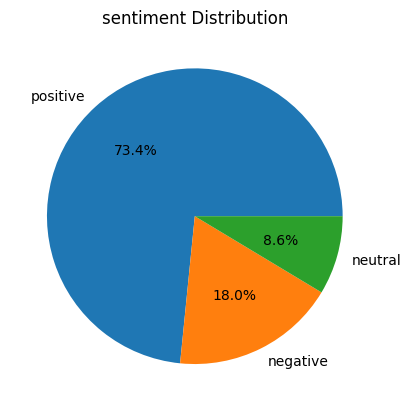

In [37]:
plt.pie(reviewdf['sentiment'].value_counts().values,
        labels=reviewdf['sentiment'].value_counts().index,
        autopct='%1.1f%%')
plt.title("sentiment Distribution")
plt.show()

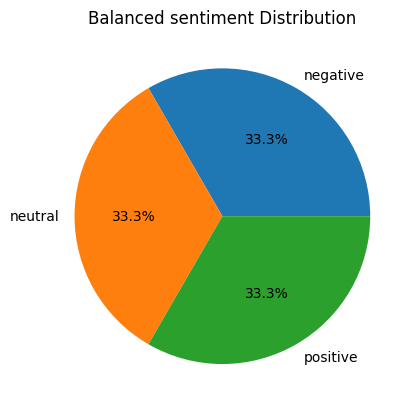

In [38]:
star1 = reviewdf[reviewdf['sentiment'] == "negative"].sample(n=500, random_state=42)
star2 = reviewdf[reviewdf['sentiment'] == "neutral"].sample(n=500, random_state=42)
star3 = reviewdf[reviewdf['sentiment'] == "positive"].sample(n=500, random_state=42)

balanced_df = pd.concat([star1, star2, star3], axis=0)

# Visualize the balanced distribution
plt.pie(balanced_df['sentiment'].value_counts().values,
        labels=balanced_df['sentiment'].value_counts().index,
        autopct='%1.1f%%')
plt.title("Balanced sentiment Distribution")
plt.show()

In [39]:

import string
reviewdf['review'] = reviewdf['review'].str.lower()

punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

reviewdf['review']= reviewdf['review'].apply(lambda x: remove_punctuations(x))
reviewdf.head()

,id,review,review_rating,word_count,sentiment
0,1,1st shipment received a book instead of the ga...,1,53,negative
1,2,i still havent figured this one out did everyt...,2,80,negative
2,3,i bought this and the key didnt work it was a...,1,37,negative
3,4,i love it use it all the time really works per...,5,20,positive
4,5,my grandkids and their parents love playing wi...,5,37,positive


In [40]:
balanced_df.head()

,id,review,review_rating,word_count,sentiment
3782,3783,Don't know what made me think Aion was going t...,1,73,negative
5590,5591,Spirit Tracks is a game more concerned with be...,2,100,negative
9805,9806,if you have watched the movie then you know ho...,1,129,negative
4590,4591,This game was a version that I never played in...,5,20,negative
10948,10949,Ok so basically they just rehashed the same ga...,2,84,negative


In [41]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

balanced_df['review'] = balanced_df['review'].apply(preprocess_text)

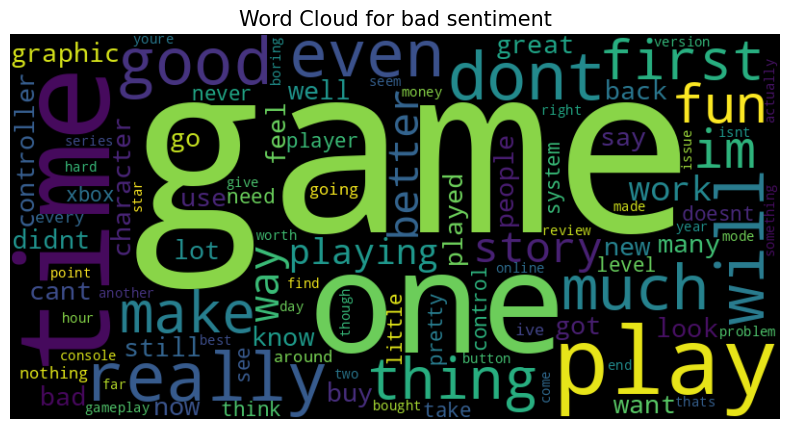

In [42]:
def plot_word_cloud(data, typ):
    corpus = " ".join(data['review'])
    wc = WordCloud(max_words=100, width=800, height=400, collocations=False).generate(corpus)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {typ} sentiment", fontsize=15)
    plt.show()

plot_word_cloud(reviewdf[reviewdf['sentiment'] == "negative"], typ="bad")

In [43]:
features = balanced_df['review']
target = balanced_df['sentiment']
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# One-hot encode the labels
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)

# Tokenization
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

In [44]:
from tensorflow import keras
from tensorflow.keras import layers

max_words = 10000
max_len = 100
#model overfitting very badly for now, going to fix over weekend
model = keras.models.Sequential([
    layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_len),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dense(512, activation='relu', kernel_regularizer='l1'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.build(input_shape=(None, max_len))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,755 (1.32 MB)

 Trainable params: 345,731 (1.32 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [45]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

In [51]:
history = model.fit(X_train_padded, Y_train,
                    validation_data=(X_val_padded, Y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[es, lr])

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.9907 - loss: 0.1795 - val_accuracy: 0.4967 - val_loss: 1.1172 - learning_rate: 0.0010
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.9826 - loss: 0.1742 - val_accuracy: 0.4700 - val_loss: 1.1065 - learning_rate: 0.0010
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9938 - loss: 0.1223 - val_accuracy: 0.5400 - val_loss: 1.0806 - learning_rate: 0.0010
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9934 - loss: 0.1122 - val_accuracy: 0.5267 - val_loss: 1.0504 - learning_rate: 0.0010
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9979 - loss: 0.0866 - val_accuracy: 0.5200 - val_loss: 1.0497 - learning_rate: 0.0010
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9999 - loss: 0.0806 - val_accuracy: 0.5333 - val_loss: 1.0587 - learning_rate: 0.0010


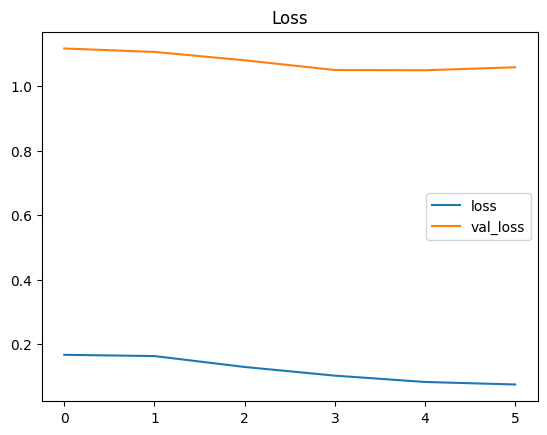

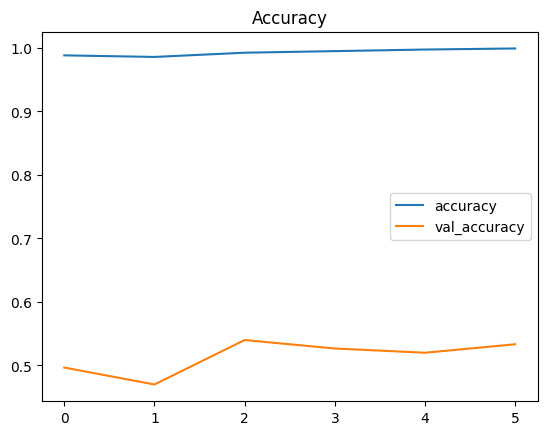

In [52]:
history_df = pd.DataFrame(history.history)

history_df[['loss', 'val_loss']].plot(title="Loss")

history_df[['accuracy', 'val_accuracy']].plot(title="Accuracy")
plt.show()

In [53]:
test_loss, test_acc = model.evaluate(X_val_padded, Y_val)
print(f"Validation Accuracy: {test_acc:.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5603 - loss: 1.0542
Validation Accuracy: 0.54
